In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import random

# seed
random.seed(113)
torch.manual_seed(113)
torch.cuda.manual_seed(113)
np.random.seed(113)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Load the Dataset

In [2]:
train_dir = "train/"
test_dir = "test/"

In [3]:
img_size = 150

train_transform = transforms.Compose([
    transforms.CenterCrop(img_size),
    transforms.RandomRotation(5), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


test_transform = transforms.Compose([
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_img = datasets.ImageFolder(train_dir, transform=train_transform)
test_img = datasets.ImageFolder(test_dir, transform=test_transform)

# Explore the Data

In [10]:
print("train_img type   :",type(train_img))
print("train_img length :",len(train_img))
print("test_img length :",len(test_img))
print("train_img classes:",train_img.classes)
print("train_img[0] type:",type(train_img[0]))
print("train_img[0][0] t:",type(train_img[0][0]))
print("train_img[0][1] t:",type(train_img[0][1]))
print("train_img[0][0] s:",train_img[0][0].size())
print("train_img[0][1]  :",train_img[0][1])

n_labels = len(train_img.classes)

train_img type   : <class 'torchvision.datasets.folder.ImageFolder'>
train_img length : 940
test_img length : 120
train_img classes: ['JUICE', 'MILK', 'SODA', 'VINEGAR', 'WATER']
train_img[0] type: <class 'tuple'>
train_img[0][0] t: <class 'torch.Tensor'>
train_img[0][1] t: <class 'int'>
train_img[0][0] s: torch.Size([3, 150, 150])
train_img[0][1]  : 0


In [11]:
def imshow(data_image, tensor=False):
    image = data_image[0]
    label = data_image[1]
    image = image.numpy().transpose((1, 2, 0))

    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5],)
    image = std * image + mean
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    plt.show()
    
    print(train_img.classes[label])

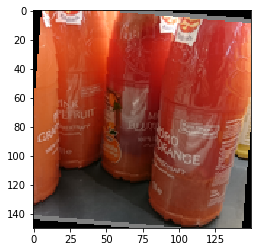

JUICE


In [12]:
imshow(train_img[0])

# Create the Loader

In [13]:
trainloaders = torch.utils.data.DataLoader(train_img, batch_size=64, shuffle=True)
testloaders = torch.utils.data.DataLoader(test_img, batch_size=32, shuffle=True)

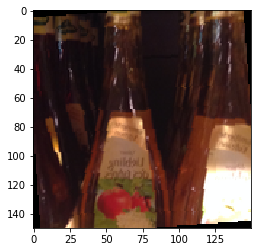

VINEGAR


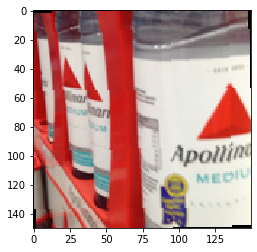

WATER


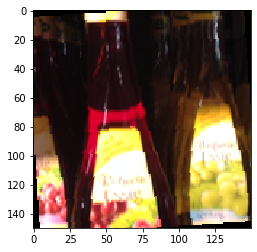

VINEGAR


In [14]:
for image, label in trainloaders:
    for i in range(3):
        imshow((image[i], label[i]))
    break

# Create the Architecture

**Attention**. There are some styles to create a model:

1. using `class`
2. using `sequential`
3. both styles combined

I suggest to use `sequential` only for a simple model, or for a simple part of the class. In the example below, you can see three different ways to create a model.

please also remember the formula to calculate the size of feature after convolution (defined in `self.conv_size()`):

$$\frac{(FEATURE - KERNEL + 2*PADDING)}{STRIDE} +1$$

In [15]:
########################
# 1. Neural Net Model using Class (the most common)
#######################

class Net(nn.Module):
    
    def __init__(self, ks=4, ps=3, fm1=16, fm2=32, n=256):
    
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, fm1, kernel_size=ks, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=ps, stride=2, padding=0)
        self.conv2 = nn.Conv2d(fm1, fm2, kernel_size=ks, stride=1, padding=0)
        
        # calculate CNN's output size
        res = self.conv_size(self.conv_size(self.conv_size(self.conv_size(img_size, ks), ps, s=2), ks), ps, s=2)**2*fm2
        
        self.fc1 = nn.Linear(res, n)
        self.fc2 = nn.Linear(n, n_labels)
        self.do = nn.Dropout()

    def conv_size(self, inp, k, p=0, s=1):
        return (inp-k+2*p)//s+1
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(x.shape[0], -1)
        x = self.do(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
    
model = Net()
model.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=36992, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
  (do): Dropout(p=0.5)
)

In [ ]:
########################
# 2. Neural Net Model using Sequential (for simple network)
#######################

class Flatten(nn.Module):
    
    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        return x
    
model = torch.nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size=4, stride=1, padding=0),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
                        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
                        Flatten(),
                        nn.Linear(39200, 512),
                        nn.ReLU(),
                        nn.Dropout(),
                        nn.Linear(512, 5))

model.to(device)

In [ ]:
########################
# 3. Neural Net Model using Sequential in Class
#######################

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.features = torch.nn.Sequential(
                            nn.Conv2d(3, 16, kernel_size=4, stride=1, padding=0),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
                            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=0))
        self.classifier = torch.nn.Sequential(
                            nn.Linear(39200, 512),
                            nn.ReLU(),
                            nn.Dropout(),
                            nn.Linear(512, 5))
    
    def forward(self, x):
        x = self.features(x)
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x
    
model = Net()
model.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epoch = 20

In [17]:
model.train()

for i in range(epoch):
    total_loss = 0
    total_sample = 0    
    total_correct = 0
    
    for image, label in trainloaders:
        image = image.to(device)
        label = label.to(device)
        
        out = model(image)
        
        loss = criterion(out, label)
        total_loss += loss.item()
        total_sample += len(label)
        total_correct += torch.sum(torch.max(out,1)[1]==label).item()*1.0
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("epoch", i, total_loss/total_sample, total_correct/total_sample)

epoch 0 0.027259800155112084 0.33191489361702126
epoch 1 0.020415747292498326 0.4797872340425532
epoch 2 0.018233101291859403 0.5457446808510639
epoch 3 0.01668914829162841 0.5851063829787234
epoch 4 0.015304566634462235 0.648936170212766
epoch 5 0.014589645634306238 0.6574468085106383
epoch 6 0.013878128313003703 0.6723404255319149
epoch 7 0.012925445272567424 0.6851063829787234
epoch 8 0.01189423457105109 0.7382978723404255
epoch 9 0.010411813252783836 0.747872340425532
epoch 10 0.009308969181902865 0.7851063829787234
epoch 11 0.008897194107796283 0.7808510638297872
epoch 12 0.00835433599162609 0.801063829787234
epoch 13 0.007175239064591997 0.8393617021276596
epoch 14 0.006102573538714267 0.8638297872340426
epoch 15 0.00588970884997794 0.8606382978723405
epoch 16 0.005066268875243816 0.9010638297872341
epoch 17 0.004473931009465076 0.9085106382978724
epoch 18 0.004152642412388579 0.9085106382978724
epoch 19 0.003921464925750773 0.9095744680851063


In [18]:
model.eval()
total_loss = 0
total_sample = 0    
total_correct = 0

for image, label in testloaders:
    image = image.to(device)
    label = label.to(device)
    
    out = model(image)

    loss = criterion(out, label)
    total_loss += loss.item()
    total_sample += len(label)
    total_correct += torch.sum(torch.max(out, 1)[1] == label).item()*1.0


print("test loss", total_loss/total_sample)
print("test accuracy", total_correct/total_sample)

test loss 0.03622708519299825
test accuracy 0.7


# Sanity Check

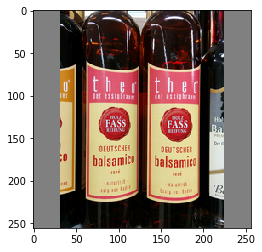

In [19]:
imagepath = "VINEGAR0139.png"
image_test = Image.open(imagepath)
plt.imshow(image_test)
plt.show()

In [20]:
image_transformed = test_transform(image_test) 
image_transformed = image_transformed.unsqueeze(0).to(device)
out = model(image_transformed)
print(out)
print("PREDICTION:", train_img.classes[torch.max(out,1)[1]])

tensor([[ 2.1500, -1.9898, -2.0099,  6.4028, -5.2399]], device='cuda:0',
       grad_fn=<AddmmBackward>)
PREDICTION: VINEGAR
